In [1]:
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
import qutip as qt

from torch.utils.data import Dataset, DataLoader
import gc

c:\Users\Adriano.Palmieri\AppData\Local\Continuum\anaconda3\envs\qiskit\lib\site-packages\qutip\__init__.py:59: UserWarning: Old version of Cython detected: needed 0.29.20, got 0.29.15.
  warnings.warn(


# upload

In [20]:
s = 1
#path = 'NNdatasets/CHECK-GHZ10000shots.npy'
#shadowpath = 'NNdatasets/WG-SHADOWH_bitflipGHZ10000shots.npy'
shadowpath = 'OAT/forPRR/sample'+str(s)+'-OATPauli85Depo0.3andMeasurementError.npy'
test = np.load(shadowpath, allow_pickle='True')
test.shape

(100, 1, 256)

In [21]:
class StatesDataset(Dataset):

    def __init__(self, x):
        super().__init__()
        self.x = x

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return self.x[index]

#train_dataset = StatesDataset(train)
#evaluation_dataset = StatesDataset(valid)

#test_dataset = StatesDataset(test)

In [4]:

class Netbeta(nn.Module):
    def __init__(self, state_local_d, num_low_triang, out_channel, nheads, dim_ff ):
        super().__init__()

        kernel = 3 #tutti i vecchi test a 50

        model_dim = state_local_d + num_low_triang*2 - kernel+1


        #ENCODING
        self.conv1 = nn.Conv1d(1, out_channel, kernel_size = kernel )

        #RECONSTRUCTION

        self.enc_transf = nn.TransformerEncoderLayer(d_model = model_dim, nhead = nheads, dim_feedforward = dim_ff, batch_first = True) # hereh hidden_size must be D-out/9 to become d_out after flattening
        self.relu = torch.nn.ReLU()
        self.enc_stack = nn.TransformerEncoder(self.enc_transf, num_layers=1)
        #self.conv2 = nn.Conv1d(out_channel, 1, kernel_size = kernel )

        self.T = torch.nn.Tanh()
        self.G = torch.nn.GELU()



        #diagonal part
        self.cholesky_diag = torch.nn.Linear(out_channel* model_dim , state_local_d)

        # (n*n +n)/2 strictly lower diagonal elements
        self.cholesky_lower_t = torch.nn.Linear(out_channel*model_dim, 2*num_low_triang)


    def forward(self, x):

        #ENCODING

        x = F.selu(self.conv1(x))

        #DECODING

        x= self.G(self.enc_stack(x))
        x = torch.flatten(x,1)

        diags = F.selu(self.cholesky_diag(x))
        off_diags = self.T(self.cholesky_lower_t(x))

        return diags, off_diags



##cholesky model

In [5]:
def return_matrix_elements(stuff,d,local_dim):

	diag_len = local_dim**d
	#print(diag_len)

	non_diag_len = (local_dim**(2*d) -diag_len)/2
	#print(non_diag_len)

	#head-up: local dim**(2d) is also the length of the initial state. The total dimension of the input is 2Xlocal dim**(2d)

	diagel = stuff[local_dim**(2*d) : local_dim**(2*d)  + diag_len  ]
	offd = stuff[ local_dim**(2*d)  + diag_len :  ]
	#print(len(imag))
	return diagel, offd



In [6]:
def rebuild_last(diags,offd,ind):
    '''''
    input.
    diags : diags elements
    offds : offdiagonal elements
    rhoshape : just the dm dimension, e.g. number of rows
    localDim : the number of level of each particle
    numParticles : the total number of particles for tensor product

    output.
    m : reconstructed cholesky decoposition matrix
    '''''
    d = len(diags)
    eye = np.eye(d,d)
    mat = np.zeros((d,d),dtype = complex)

    offvalues = [ (a+1j*b) for (a,b) in zip(offd[:int(len(offd)/2 ) ], offd[int(len(offd)/2):])  ]
    mat[ind[0], ind[1]] = offvalues

    return mat + eye*diags

## SOME NETWORK PARAMETERS

In [7]:
local_dim = 16
dim = 1
batch_size = 2000


device = torch.device('cpu')

themodelbeta = torch.load('4qubitsHaarModels/4qubitWithCholLayersTransformer100000-fid993multinomial.pth',map_location=device)
themodelbeta.eval()

Netbeta(
  (conv1): Conv1d(1, 3, kernel_size=(3,), stride=(1,))
  (enc_transf): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=254, out_features=254, bias=True)
    )
    (linear1): Linear(in_features=254, out_features=30, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=30, out_features=254, bias=True)
    (norm1): LayerNorm((254,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((254,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (relu): ReLU()
  (enc_stack): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=254, out_features=254, bias=True)
        )
        (linear1): Linear(in_features=254, out_features=30, bias=True)
        (dr

### TESTING

In [22]:
#just generate ones the index for the recosntruction using a dull matrix

def fid(a,b):
  fid = qt.fidelity(qt.Qobj(a), qt.Qobj(b))
  return torch.tensor(fid)

#parameters
qfid =0
j=0
hs = []
fids =[]

# generate support diagonal matrix for reconstruction
e = np.eye(local_dim**(dim),local_dim**(dim))
print(e.shape)

#indeces for the reconstruction function
ind = np.tril_indices_from(e,k=-1)



(16, 16)


In [23]:

test_dataset = StatesDataset(test)
gl_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size = batch_size, shuffle =False,
    pin_memory = True)

In [24]:
file_ = []
originals = []


with torch.no_grad():
  for inputsT in gl_dataloader:

    inputsT = inputsT.to(device)

    #out_d is the diagonal, out_tr the triangluar values, real and complex altogether
    newinT = torch.reshape(inputsT[:,:local_dim**(2*dim)  ], (inputsT.shape[0],1,local_dim**2) )

    out_d, out_tr = themodelbeta(newinT)

    for i in range(out_d.shape[0]):

      #reconstructing cholesky from dataset input array. NO MORE NEEDED
      #diagel, offd = return_matrix_elements( inputsT[i].cpu().numpy(), dim, local_dim)

      #original_chol = rebuild_last(diagel, offd , ind)

      #reconstructing cholesky from neural network outputs

      nn_diag = out_d[i].cpu().numpy()
      nn_offd = out_tr[i,:int(out_tr.shape[1])].cpu().numpy()

      nn_chol = rebuild_last(nn_diag, nn_offd, ind)

      cholo=nn_chol@ nn_chol.conj().T

      norm = np.trace(cholo)

      file_.append(cholo/norm)


## OAT STATE TEST

In [25]:
len(file_)

100

In [12]:
import pandas as pd

ofd = pd.read_pickle('OAT/outofdistribution100.pkl')

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

In [26]:

add = []
list(ofd),np.array(file_).shape
add = []
for step in range(100):
    add.append(fid(ofd['rho_target'][step],file_[step]))

print(np.mean(add),np.std(add))


0.94848025 0.013588594


In [ ]:
##MY TARGET STATE
ghz = np.zeros((16,16))
ghz[0,0]=1
ghz[-1,-1]=1
#antidiagonal elements
ghz[0,-1]=1
ghz[-1,0]=1

#ANTI GHZ
antighz = np.zeros((16,16))
antighz[0,0]=1
antighz[-1,-1]=1
#antidiagonal elements
antighz[0,-1]=-1
antighz[-1,0]=-1

ghztarget = 0.5*np.array(ghz)
antighztarget = 0.5*np.array(antighz)
targetrandom = np.load('SampledStatesFromCircuit/TargetRandomState.npy')#da generare di nuovo
targetH_bitflip = np.load('SampledStatesFromCircuit/HadambitflipGHZ.npy')
#hbfghz = np.load('SampledStatesFromCircuit/HadambitflipGHZ.npy')

In [ ]:
add = []
for step in range(len(file_)):
    add.append(fid(ghztarget,file_[step]))

In [ ]:
np.min(add), np.max(add)

In [ ]:
print(np.mean(add),np.std(add), len(add), shadowpath)


## Saving file_ & delating test dataset

In [ ]:
np.save('plots/NN-Outputs/NNOUT-'+shadowpath[11:],add)
del(gl_dataloader)
del(test)
gc.collect()

In [ ]:
print(shadowpath[11:])

## BELL CORRELATORS

In [14]:
X = np.array([[0,1],[1,0]])/2
Y = np.array([[0,-1j],[1j,0]])/2
Z = np.array( [[1,0],[0,-1]]  )/2
N= 4


def J(o):
    "Computes the matrix representation of the collective operator J=\sum_{i=1}^No^{(i)} in the computational basis"
    def O(i):
        return np.kron(np.identity(2**i),np.kron(o,np.identity(2**(N-i-1))))
    return np.sum([O(i) for i in range(N)],0)

def QFI(rho, G):
    Eigen_vals, eigen_vecs = np.linalg.eigh(rho)
    qfi_val=0.0
    for i in range(len(Eigen_vals)):
       for j in range(len(Eigen_vals)):
           if Eigen_vals[i]+Eigen_vals[j]>1e-10:
                J_z_i_j = (eigen_vecs[:, i].conjugate().transpose() @ G) @ eigen_vecs[:, j]
                qfi_val += (((Eigen_vals[i] - Eigen_vals[j])**2)/(Eigen_vals[i]+Eigen_vals[j]))*(np.abs(J_z_i_j))**2
    return 2*qfi_val.real

In [15]:
Jx = J(X)
Jz = J(Z)
Jy = J(Y)

def Jav(r):

    return (np.trace(r@Jx))**2 + (np.trace(r@Jy))**2  + (np.trace(r@Jz))**2 

In [27]:
Javlist = []
Jbells = []
JLi = []

for step in range(100):
    Javlist.append(Jav(ofd['rho_target'][step]))

for step in range(100):
    Jbells.append(Jav(file_[step]))

for step in range(100):
    liInputStates = rebuild_last(test[step][0][:16],test[step][0][16:],ind)
    JLi.append(Jav(liInputStates @ liInputStates.T.conj()))

In [28]:
def corr(rho):
    Jvect = [Jx,Jy,Jz]

    C = np.real([[np.trace(Jvect[a] @ Jvect[b] @ rho) for a in range(3)] for b in range(3)])
    M = np.real([[np.trace(Jvect[a] @ rho)*np.trace(Jvect[b] @ rho) for a in range(3)] for b in range(3)])
    return C - M
    

In [29]:
corrtarget = []
corrnn = []
corrli = []

LI_dm = []

for step in range(100):
    corrtarget.append(corr(ofd['rho_target'][step]))
    corrnn.append(corr(file_[step]))

    liInputs = rebuild_last(test[step][0][:16],test[step][0][16:],ind)
    LI_dm.append(liInputs @ liInputs.T.conj())
    
    corrli.append(corr(liInputs @ liInputs.T.conj()))

def maxEigandeigv(r):

    _, vector = np.linalg.eigh(r)
    return vector[:,-1]


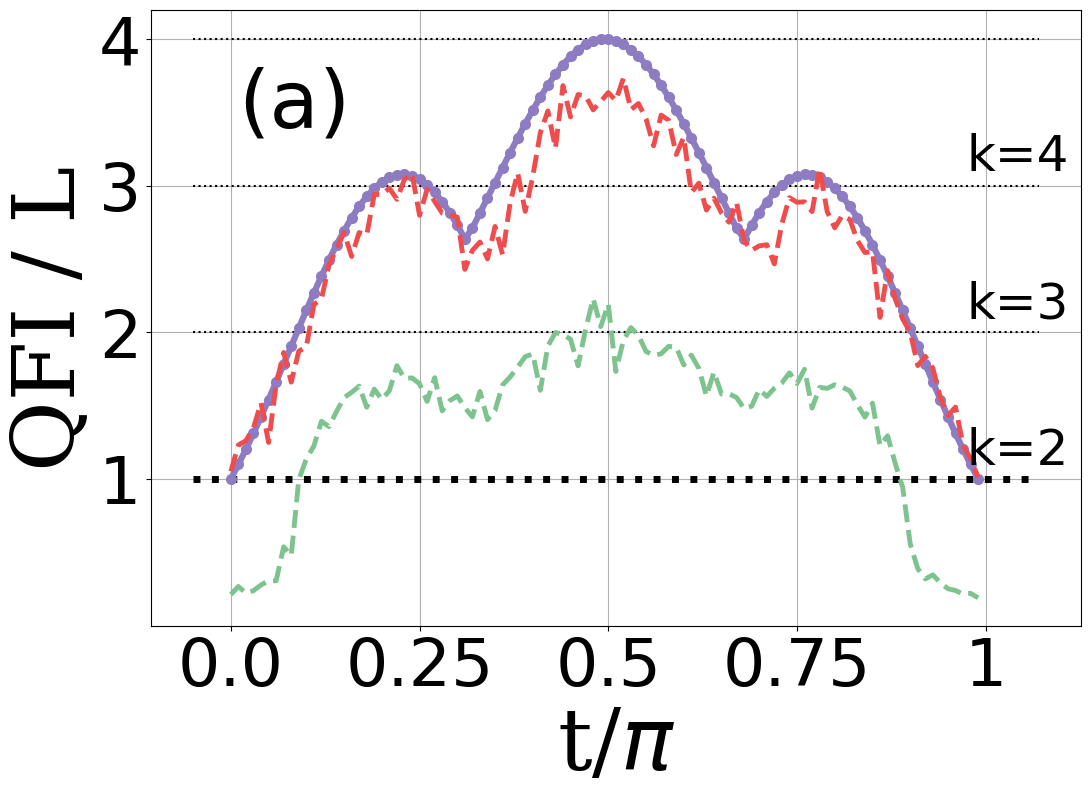

In [30]:
import matplotlib.pyplot as plt



font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

fig = plt.figure(figsize=(12,8))
ax=  plt.subplot()
ax.set(ylim=([0, 4.2]))
triadic = ['#8e7cc3','#7cc38e','#f14c4c']
passi = 100

nt = '10^5trials-'



#This is for QUANTUM fisher


ytarget= [ max(np.linalg.eigvals(m)) for m in corrtarget ]
y2t = [ max(np.linalg.eigvals(m2)) for m2 in corrnn ]

y2x = [ maxEigandeigv(m2) for m2 in corrnn ]

y2 = [ QFI(np.array(n), y2x[m][0]*Jx+ y2x[m][1]*Jy+ y2x[m][2]*Jz ) for m,n in zip(range(len(y2x)),file_) ]

#y3t = [ max(np.linalg.eigvals(m2)) for m2 in corrli ]
#y3x = [ maxEigandeigv(m3) for m3 in corrli ]
#y3 = [ QFI(np.array(n), y3x[m][0]*Jx+ y3x[m][1]*Jy+ y3x[m][2]*Jz ) for m,n in zip(range(len(y3x)),LI_dm) ]
y3t = [ max(np.linalg.eigvals(m2)) for m2 in corrli ]
y3x = [ maxEigandeigv(m3) for m3 in corrli ]
y3 = [ QFI(np.array(n), y3x[m][0]*Jx+ y3x[m][1]*Jy+ y3x[m][2]*Jz ) for m,n in zip(range(len(y3x)),LI_dm) ]

np.save('OAT/forPRR/4qubitsOAT-DEPO03/Fisherytarget-'+str(s)+'.npy',ytarget)
np.save('OAT/forPRR/4qubitsOAT-DEPO03/Fishery2-'+str(s)+'.npy',y2)
np.save('OAT/forPRR/4qubitsOAT-DEPO03/Fishery3-'+str(s)+'.npy',y3)

t = np.arange(passi)
ax.plot(t/passi, ytarget, label = 'target', color = triadic[0],linewidth = 4.5, marker = 'o', markersize = 7)
ax.plot(t/passi,np.array(y2)/4, label = 'reconstructed 10^5', color = triadic[2],linestyle = '--', linewidth = 3.5)
ax.plot(t/passi,np.array(y3)/4, label = 'max eig QFI LI', color = triadic[1],linestyle = '--', linewidth = 3.5)


ax.text(0.01,3.4,'(a)', fontsize = 58)

ax.hlines(1,-0.05,1.07, color = 'black', linestyle = 'dotted', alpha = 1,linewidth=5)
ax.hlines(2,-0.05,1.07, color = 'black', linestyle = 'dotted', alpha = 1)
ax.hlines(3,-0.05,1.07, color = 'black', linestyle = 'dotted', alpha = 1)
ax.hlines(4,-0.05,1.07, color = 'black', linestyle = 'dotted', alpha = 1)

ax.text(0.975,1.1, "k=2", fontsize = 36, fontdict = {'family': 'cursive'})
ax.text(0.975,2.1, "k=3", fontsize = 36, fontdict = {'family': 'cursive'})
ax.text(0.975,3.1, "k=4", fontsize = 36, fontdict = {'family': 'cursive'})

ax.set_xticks([0.0,0.25,0.5,0.75,1])
ax.xaxis.set_ticklabels([0.0,0.25,0.5,0.75,1])
ax.set_ylabel('QFI / L', fontsize = 58+4, fontdict={'family':'serif'})
ax.set_xlabel('t/$\pi$', fontsize = 58+4,fontdict={'family':'serif'})
ax.set_yticks([1,2,3,4])
#ax.yaxis.set_ticklabels([]) #this is to hide the text below x axis
plt.xticks(size = 48)
plt.yticks(size = 48)

#plt.legend(prop={'size': 12},frameon=False, fancybox = False)
plt.savefig('OAT/forPRR/plots/'+str(s)+'-FisherFromPauli-OATDepo0.3MeasError.pdf', format = 'pdf',bbox_inches="tight")

ax.grid()

FileNotFoundError: [Errno 2] No such file or directory: '4qubitsOAT-TestSet/articlePlotSics100K/SSytargetNormalize-2.npy'

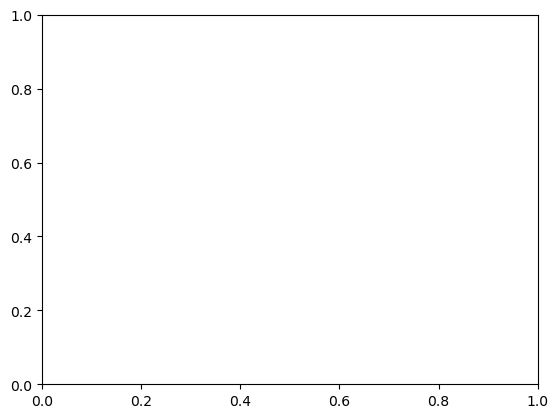

In [21]:
import matplotlib.pyplot as plt

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }


nt = '10^5trials-'
fig, ax = plt.subplots()

#This is for spin squeeze
nytarget= [ min(np.linalg.eigvals(m[1:3,1:3])) for m in corrtarget ]
ny2 = [ min(np.linalg.eigvals(m2[1:3, 1:3])) for m2 in corrnn ]
ny3 = [ min(np.linalg.eigvals(m3[1:3, 1:3])) for m3 in corrli ]


ytargetNormalize = np.array(Javlist)/np.array(nytarget)  #[ a.real/b.real for a,b in zip(Javlist, ytarget)  ]
y2Normalize = [ a.real/b.real for a,b in zip(Jbells, ny2)  ]
y3Normalize = [ a.real/b.real for a,b in zip(JLi, ny3)  ]

np.save('4qubitsOAT-TestSet/articlePlotSics100K/SSytargetNormalize-'+str(s)+'.npy',ytargetNormalize)
np.save('4qubitsOAT-TestSet/articlePlotSics100K/SSy2Normalize-'+str(s)+'.npy',y2Normalize)
np.save('4qubitsOAT-TestSet/articlePlotSics100K/SSy3Normalize-'+str(s)+'.npy',y3Normalize)

t = np.arange(100)

ax.scatter(t/100, ytargetNormalize, label = 'target', color = triadic[0])
ax.plot(t/100, y2Normalize, label = 'reconstructed 10^5', color = triadic[1])
ax.plot(t/100, y3Normalize, label = 'LI reconstruction 10^5', color = triadic[2])
plt.xlabel('t/pi', fontsize = 15)
plt.ylabel('Spin squeezing', fontsize =15)
plt.title("Spin squeezing from Pauli", fontdict = font)

ax.xaxis.set_tick_params(width= 2)
ax.yaxis.set_tick_params(width= 2)
plt.tick_params(axis='both', which='major', labelsize=14)

plt.legend(loc = 'upper right', prop={'size': 10},frameon=False, fancybox = False)
#plt.savefig(nt+'SSFromPauli-OATreconstructedStates100steps.pdf', format = 'pdf',bbox_inches="tight")

ax.grid()